# Book Code

In [5]:
import pandas as pd

df = pd.read_csv("tate.csv.gz", index_col='artId')
df[["artist", "acquisitionYear", "accession_number", "medium", "width", "height"]].head(2)

,artist,acquisitionYear,accession_number,medium,width,height
artId,,,,,,
1035,"Blake, Robert",1922.0,A00001,"Watercolour, ink, chalk and graphite on paper....",419,394
1036,"Blake, Robert",1922.0,A00002,Graphite on paper,213,311


In [7]:
import numpy as np

df = df.loc[(df['width'] < 8000) & (df['height'] < 8000)]
df = df.loc[(df['width'] >= 20) & (df['height'] >= 20)]

df["width_log10"] = np.log10(df["width"])
df["height_log10"] = np.log10(df["height"])

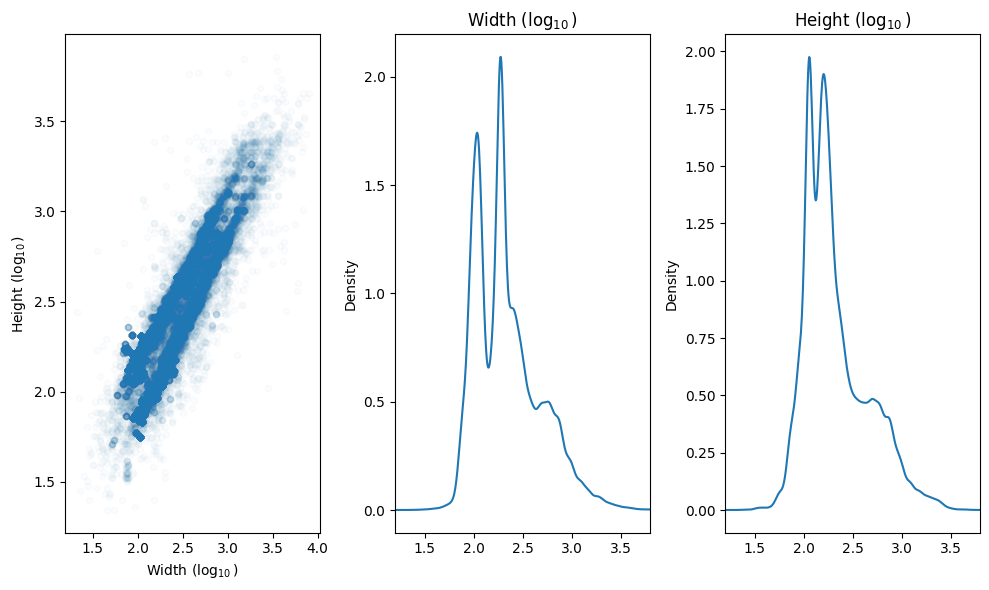

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
df.plot(x='width_log10', y='height_log10', kind='scatter', alpha=0.02, ax=axes[0])
axes[0].set(xlabel=r'Width ($\log_{10}$)', ylabel=r'Height ($\log_{10}$)')

df['width_log10'].plot(kind='density', title=r'Width ($\log_{10}$)', ax=axes[1])
df['height_log10'].plot(kind='density', title=r'Height ($\log_{10}$)', ax=axes[2])
xlim = (1.2, 3.8); axes[1].set_xlim(*xlim); axes[2].set_xlim(*xlim)
plt.tight_layout();

In [9]:
import sklearn.mixture as mixture

gmm = mixture.BayesianGaussianMixture(n_components=3, max_iter=200)
gmm.fit(df[['width_log10', 'height_log10']])

# order of components is arbitrary, sort by mixing proportions (decending)
order = np.argsort(gmm.weights_)[::-1]
means, covariances, weights = gmm.means_[order], gmm.covariances_[order], gmm.weights_[order]

# mu_1, mu_2, mu_3 in the equation above
print("μ's =", means.round(2))
# Sigma_1, Sigma_2, Sigma_3 in the equation above
print("Σ's =", covariances.round(4))
# theta_1, theta_2, theta_3 in the equation above
print("θ's =", weights.round(2))

μ's = [[2.55 2.56]
 [2.28 2.11]
 [2.01 2.21]]
Σ's = [[[0.1358 0.1111]
  [0.1111 0.1142]]

 [[0.0212 0.0214]
  [0.0214 0.0237]]

 [[0.0046 0.0041]
  [0.0041 0.0046]]]
θ's = [0.43 0.37 0.21]


In [12]:
import os
import gzip
import pandas as pd

with gzip.open('supreme-court-opinions-by-author.jsonl.gz', 'rt') as fh:
    df = pd.read_json(fh, lines=True).set_index(['us_reports_citation', 'authors'])

df.loc['323 US 214']

,case_id,text,type,year
authors,,,,
black,1944-018,\nOPINION BY: BLACK\nOPINION\nMR. JUSTICE BLAC...,opinion,1944
frankfurter,1944-018,\nCONCUR BY: FRANKFURTER\nMR. JUSTICE FRANKFUR...,concur,1944
roberts_o,1944-018,\nDISSENT BY: ROBERTS; MURPHY; JACKSON\nMR. JU...,dissent,1944
murphy,1944-018,"\nMR. JUSTICE MURPHY, dissenting.\nThis exclus...",dissent,1944
jackson_r,1944-018,"\nMR. JUSTICE JACKSON, dissenting.\nKorematsu ...",dissent,1944


In [13]:
print(df.loc['323 US 214'].loc['murphy', 'text'][:500])


MR. JUSTICE MURPHY, dissenting.
This exclusion of "all persons of Japanese ancestry, both alien and non-alien," from the Pacific Coast area on a plea of military necessity in the absence of martial law ought not to be approved.  Such exclusion goes over "the very brink of constitutional power" and falls into the ugly abyss of racism.
In dealing with matters relating to the prosecution and progress of a war, we must accord great respect and consideration to the judgments of the military authorit


,year
count,34677.000000
mean,1928.824552
std,48.821262
min,1794.000000
25%,1890.000000
50%,1927.000000
75%,1974.000000
max,2008.000000


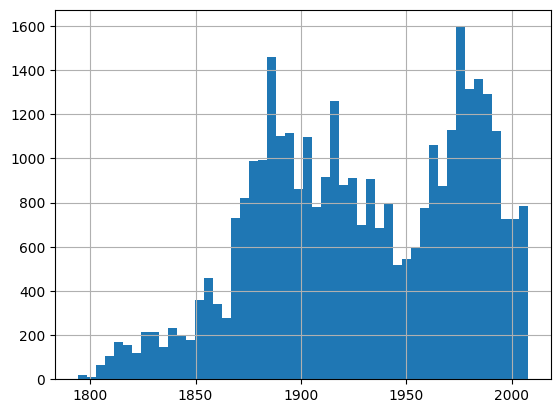

In [15]:
df['year'].hist(bins=50)
df['year'].describe()

In [16]:
import sklearn.feature_extraction.text as text

# min_df: ignore words occurring in fewer than `n` documents
# stop_words: ignore very common words ("the", "and", "or", "to", ...)
vec = text.CountVectorizer(lowercase=True, min_df=100, stop_words='english')
dtm = vec.fit_transform(df['text'])

In [17]:
print(f'Shape of document-term matrix: {dtm.shape}. '
      f'Number of tokens {dtm.sum()}')

Shape of document-term matrix: (34677, 13231). Number of tokens 36139890


In [18]:
import sklearn.decomposition as decomposition
model = decomposition.LatentDirichletAllocation(
    n_components=100, learning_method='online', random_state=1)

In [19]:
document_topic_distributions = model.fit_transform(dtm)

In [21]:
vocabulary = vec.get_feature_names_out()
assert model.components_.shape == (100, len(vocabulary))
assert document_topic_distributions.shape == (dtm.shape[0], 100)

In [20]:
topic_names = [f'Topic {k}' for k in range(100)]
topic_word_distributions = pd.DataFrame(
    model.components_, columns=vocabulary, index=topic_names)
document_topic_distributions = pd.DataFrame(
    document_topic_distributions, columns=topic_names, index=df.index)

document_topic_distributions.loc['323 US 214'].loc['murphy'].head(10)

NameError: name 'vocabulary' is not defined

In [23]:
murphy_dissent = document_topic_distributions.loc['323 US 214'].loc['murphy']
murphy_dissent.sort_values(ascending=False).head(10)

,murphy
Topic 8,0.111934
Topic 49,0.105802
Topic 17,0.090878
Topic 44,0.088893
Topic 93,0.071995
Topic 12,0.068529
Topic 35,0.061863
Topic 22,0.060224
Topic 52,0.053225
Topic 23,0.046771


In [24]:
topic_word_distributions.loc['Topic 8'].sort_values(ascending=False).head(18)

,Topic 8
state,7423.743632
political,5763.436445
equal,5357.940314
voting,5218.087219
vote,4967.097213
district,4892.887730
race,4834.578115
court,4516.218149
districts,4058.671278
citizens,3721.802863


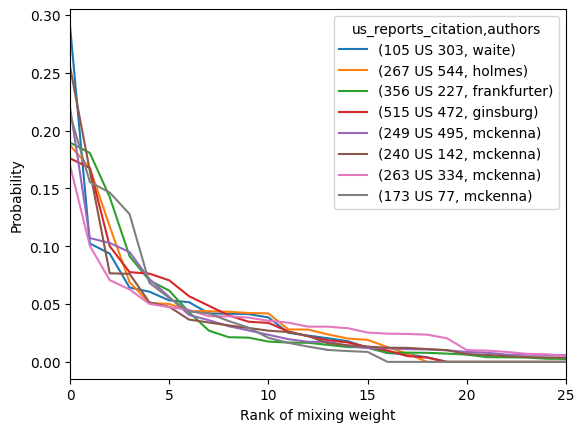

In [25]:
weights_sample = document_topic_distributions.sample(8)
weights_ordered = weights_sample.apply(
    lambda row: row.sort_values(ascending=False).reset_index(drop=True), axis=1)
# transpose DataFrame so pandas plots weights on correct axis
ax = weights_ordered.T.plot()
ax.set(xlabel='Rank of mixing weight', ylabel='Probability', xlim=(0, 25));

In [27]:
# issueArea is coded as int but pandas does not allow us to mix int and
# values indicating NaN, so we represent the issueArea codes as `float`
# as a compromise.
scdb = pd.read_csv('SCDB_2016_01_caseCentered_Citation.csv.zip',
                   dtype={'issueArea': float}, encoding='latin1', index_col='caseId')
df_after_1945 = df.loc[df.case_id.isin(scdb.index)]
df_after_1945 = df_after_1945.join(scdb['issueArea'], on='case_id')

In [28]:
# for issueArea labels see SCDB documentation
# Exclude label 14 ("Private Action") as none of the opinions are
# assigned this label
spaeth_issue_areas = {
    1: "Criminal Procedure",
    2: "Civil Rights",
    3: "First Amendment",
    4: "Due Process",
    5: "Privacy",
    6: "Attorneys",
    7: "Unions",
    8: "Economic Activity",
    9: "Judicial Power",
    10: "Federalism",
    11: "Interstate Relations",
    12: "Federal Taxation",
    13: "Miscellaneous",
}
df_after_1945["issueArea"] = pd.Categorical(
    df_after_1945["issueArea"].replace(spaeth_issue_areas),
    categories=spaeth_issue_areas.values())

In [29]:
import collections

[(issue_area, count)] = collections.Counter(df_after_1945['issueArea']).most_common(1)
print(f'Issue area `{issue_area}` associated with {count} opinions, '
      f'{count / len(df_after_1945):.0%} of all opinions.')

Issue area `Criminal Procedure` associated with 3444 opinions, 25% of all opinions.


In [32]:
document_word_counts = dtm.toarray().sum(axis=1)
document_topic_word_counts = document_topic_distributions.multiply(
    document_word_counts, axis='index'
)

df_after_1945.groupby('issueArea')["Topic 3"].sum()

<ipython-input-32-8fdcde3317e1>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_after_1945.groupby('issueArea')["Topic 3"].sum()


,Topic 3
issueArea,
Criminal Procedure,185265.274535
Civil Rights,12234.033907
First Amendment,3031.773717
Due Process,6704.032155
Privacy,1365.398311
Attorneys,341.275008
Unions,323.901757
Economic Activity,3823.773399
Judicial Power,3211.099456


In [33]:
topic_word_distributions.loc['Topic 3'].sort_values(ascending=False).head()

,Topic 3
sentence,11761.431514
death,11408.959135
sentencing,7705.292340
penalty,7531.424915
capital,4475.421839


In [35]:
# each tuple records the following in the order used by Lauderdale and Clark:
# (<Lauderdale and Clark top words>, <our topic number>, <our top words>)
lauderdale_clark_figure_3_mapping = (
    ('lands, indian, land', 59, 'indian, territory, indians'),
    ('tax, commerce, interstate', 89, 'commerce, interstate, state'),
    ('federal, immunity, law', 2, 'suit, action, states, ..., immunity'),
    ('military, aliens, aliens', 22, '..., alien,..., aliens, ..., deportation, immigration'),
    ('property, income, tax', 79, 'tax, taxes, property'),
    ('district, habeas, appeal', 43, 'court, federal, district, appeals, review, courts, habeas'),
    ('negligence, maritime, admiralty', 7, 'vessel, ship, admiralty'),
    ('patent, copyright, cable', 86, 'patent, ..., invention, patents'),
    ('search, fourth, warrant', 37, 'search, warrant, fourth'),
    ('jury, death, penalty', 3, 'sentence, death, sentencing, penalty'),
    ('school, religious, schools', 73, 'religious, funds, ... government, ..., establishment'),
    ('trial, counsel, testimony', 13, 'counsel, trial, defendant'),
    ('epa, waste, safety', 95, 'regulations, ..., agency, ..., safety, ..., air, epa' ),
    ('speech, ordinance, public', 58, 'speech, amendment, .., public'),
    ('antitrust, price, securities', 39, 'market, price, competition, act, antitrust'),
    ('child, abortion, children', 14, 'child, children, medical, ..., woman, ... abortion'),
    ('prison, inmates, parole', 67, 'prison, release, custody, parole' ),
    ('political, election, party', 23, 'speech, amendment, ..., political, party'),
    ('title, vii, employment', 55, 'title, discrimination, ..., vii'),
    ('offense, criminal, jeopardy', 78, 'criminal, ..., crime, offense'),
    ('union, labor, board', 24, 'board, union, labor'),
    ('damages, fees, attorneys', 87, 'attorney, fees, ..., costs'),
    ('commission, rates, gas', 97, 'rate, ..., gas, ..., rates'),
    ('congress, act, usc', 41, 'federal, congress, act, law'),
)

<ipython-input-36-a6281d03fc4b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_after_1945.groupby('issueArea')[figure_3_topic_names].sum()


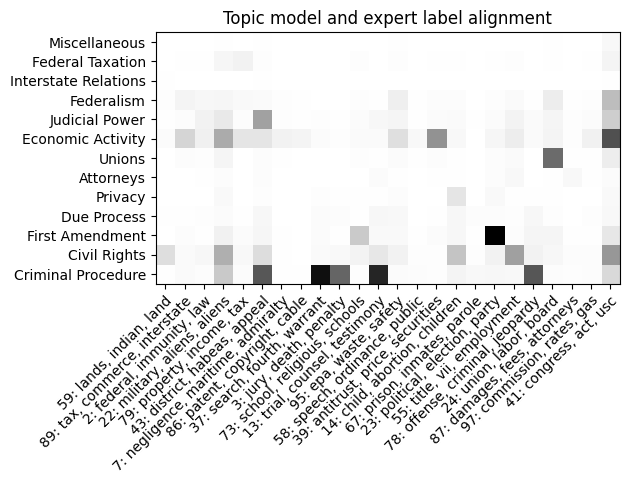

In [36]:
figure_3_topic_names = [f'Topic {t}' for _, t, _ in lauderdale_clark_figure_3_mapping]
df_plot = df_after_1945.groupby('issueArea')[figure_3_topic_names].sum()
df_plot = df_plot.rename(columns={
    f'Topic {t}': f'{t}: {figure_3_words}'
    for figure_3_words, t, _ in lauderdale_clark_figure_3_mapping
})
# heatmap code adapted from matplotlib documentation:
# https://matplotlib.org/gallery/images_contours_and_fields/
# image_annotated_heatmap.html

# `numpy.flipud` flips y-axis (to align with Lauderdale and Clark)
fig, ax = plt.subplots()
im = ax.imshow(np.flipud(df_plot.values), cmap="Greys")

ax.set_xticks(np.arange(len(df_plot.columns)))
ax.set_yticks(np.arange(len(df_plot.index)))
ax.set_xticklabels(df_plot.columns)
ax.set_yticklabels(reversed(df_plot.index))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title('Topic model and expert label alignment')
fig.tight_layout()

In [37]:
minor_top_topics = topic_word_distributions['minor'].sort_values(ascending=False).head(5)
minor_top_topics_top_words = topic_word_distributions.loc[minor_top_topics.index].apply(
        lambda row: ', '.join(row.sort_values(ascending=False).head().index),
        axis=1,
)
minor_top_topics_top_words.name = 'topic_top_words'
minor_top_topics.to_frame().join(minor_top_topics_top_words)

,minor,topic_top_words
Topic 14,1392.510236,"child, children, medical, health, women"
Topic 50,714.482133,"estate, death, wife, husband, mrs"
Topic 40,349.211324,"court, ante, justice, majority, dissent"
Topic 44,232.288472,"use, area, new, economic, substantial"
Topic 78,221.881174,"criminal, states, united, indictment, crime"


In [38]:
opinion_of_interest = ('483 US 587', 'brennan')
document_topic_distributions.loc[opinion_of_interest, minor_top_topics.index]

<ipython-input-38-6c24fed987bc>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, minor_top_topics.index]


,,Topic 14,Topic 50,Topic 40,Topic 44,Topic 78
us_reports_citation,authors,,,,,
483 US 587,brennan,0.442462,0.017859,0.040139,0.092659,0.000003


In [39]:
print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])

ng personal behavior.  On certain occasions, however, government intrusion into private life is so direct and substantial that we must deem it intolerable if we are to be true to our belief that there is a boundary between the public citizen and the private person.
This is such a case.  The Government has told a child who lives with a mother receiving public assistance that it cannot both live with its mother and be supported by its father.  The child must either leave the care and custody of the mother, or forgo the support of the father and become a Government client. The child is put to this choice not because it seeks Government benefits for itself, but because of a fact over which it has no control: the need of other household members for public assistance. A child who lives with one parent has, under the best of circumstances, a difficult time sustaining a relationship with both its parents.  A crucial bond between a child and its parent outside the home, usually the father, is t

<ipython-input-39-5a19aca8e5fb>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])


In [41]:
opinion_of_interest = ('479 US 189', 'white_b')
print(f'"minor" count in 479 US 189:', sum('minor' in word.lower()
          for word in df.loc[opinion_of_interest, 'text'].values[0].split()))
document_topic_distributions.loc[opinion_of_interest, minor_top_topics.index.tolist() + ['Topic 23']]

"minor" count in 479 US 189: 21


<ipython-input-41-722beb311c60>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  for word in df.loc[opinion_of_interest, 'text'].values[0].split()))
<ipython-input-41-722beb311c60>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, minor_top_topics.index.tolist() + ['Topic 23']]


,,Topic 14,Topic 50,Topic 40,Topic 44,Topic 78,Topic 23
us_reports_citation,authors,,,,,,
479 US 189,white_b,0.023406,0.000007,0.115436,0.038544,0.000007,0.149759


In [42]:
topic_oi = 'Topic 23'
topic_oi_words = ', '.join(
    topic_word_distributions.loc[topic_oi].sort_values(ascending=False).head(8).index)
print(f'Topic 23 top words:\n  {topic_oi_words}')

Topic 23 top words:
  speech, amendment, government, political, party, press, freedom, free


In [43]:
print(df.loc[opinion_of_interest, 'text'][0][1000:1500])

held on the same day as the primary election for "major" parties. 1 The convention-nominated, minor-party candidate secured a position on the general election ballot upon the filing of a certificate signed by at least 100 registered voters who had participated in the convention and who had not voted in the primary election. 2  The 1977 amendments retained the requirement that a minor-party candidate be nominated by convention, 3 but imposed the additional requirement that, as a precondition to g


<ipython-input-43-2e0888bbe2df>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[opinion_of_interest, 'text'][0][1000:1500])
<ipython-input-43-2e0888bbe2df>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df.loc[opinion_of_interest, 'text'][0][1000:1500])


In [44]:
import itertools

opinion_text = df.loc[opinion_of_interest, 'text'][0]
window_width, num_words = 3, len(opinion_text.split())
words = iter(opinion_text.split())
windows = [
    ' '.join(itertools.islice(words, 0, window_width))
    for _ in range(num_words // window_width)
]
print([window for window in windows if 'minor' in window])

['a minor-party candidate', 'candidates from minor', 'amendments, a minor-party', 'minor-party candidate secured', 'that a minor-party', 'a minor-party or', 'and minor-party candidates,', 'candidates of minor', 'minor parties who', 'number of minor', 'minor parties having', 'virtually every minor-party', 'of 12 minor-party', 'minor-party ballot access.', 'that minor parties', 'about how minor', "minor party's qualification", 'primary," minor-party candidates', 'which minor-party candidates', 'a minor-party candidate']


<ipython-input-44-2809ee023266>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  opinion_text = df.loc[opinion_of_interest, 'text'][0]
<ipython-input-44-2809ee023266>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  opinion_text = df.loc[opinion_of_interest, 'text'][0]


In [46]:
labor_topic = 'Topic 24'
topic_word_distributions.loc[labor_topic].sort_values(ascending=False).head(10)

,Topic 24
board,23593.337446
union,22111.377863
labor,16687.690239
employees,9523.078246
bargaining,7999.962729
act,6221.954100
employer,5935.989537
collective,5838.038565
agreement,4569.440541
relations,3802.370509


In [47]:
topic_top_words = topic_word_distributions.loc[labor_topic].sort_values(
    ascending=False).head(10).index
topic_top_words_joined = ', '.join(topic_top_words)
print(topic_top_words_joined)

board, union, labor, employees, bargaining, act, employer, collective, agreement, relations


In [48]:
# convert `dtm` (matrix) into an array:
opinion_word_counts = np.array(dtm.sum(axis=1)).ravel()
word_counts_by_year = pd.Series(opinion_word_counts).groupby(df.year.values).sum()
topic_word_counts = document_topic_distributions.multiply(opinion_word_counts,
                                                          axis='index')
topic_word_counts_by_year = topic_word_counts.groupby(df.year.values).sum()
topic_proportion_by_year = topic_word_counts_by_year.divide(word_counts_by_year,
                                                            axis='index')

topic_proportion_by_year.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 90,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99
1794,0.000038,0.019573,0.000038,0.000038,0.021096,0.000038,0.000038,0.013707,0.000038,0.000038,...,0.000038,0.000038,0.000038,0.210499,0.002054,0.000038,0.000038,0.000038,0.000038,0.000038
1795,0.000026,0.014169,0.000026,0.000026,0.025628,0.000026,0.000026,0.106625,0.000026,0.000026,...,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
1796,0.000028,0.036382,0.000028,0.000028,0.004396,0.032959,0.000028,0.021983,0.009850,0.000028,...,0.000028,0.015842,0.000028,0.130444,0.002253,0.000028,0.000028,0.004262,0.000028,0.000028
1797,0.000026,0.015645,0.000026,0.000026,0.010891,0.098829,0.000026,0.081282,0.000026,0.000026,...,0.000026,0.007088,0.011393,0.083118,0.000026,0.000026,0.000026,0.002262,0.000026,0.000026
1798,0.000352,0.009832,0.003496,0.001023,0.002399,0.121964,0.000010,0.000010,0.000010,0.000981,...,0.051774,0.013590,0.002891,0.075408,0.000010,0.000010,0.000010,0.002979,0.000010,0.000010


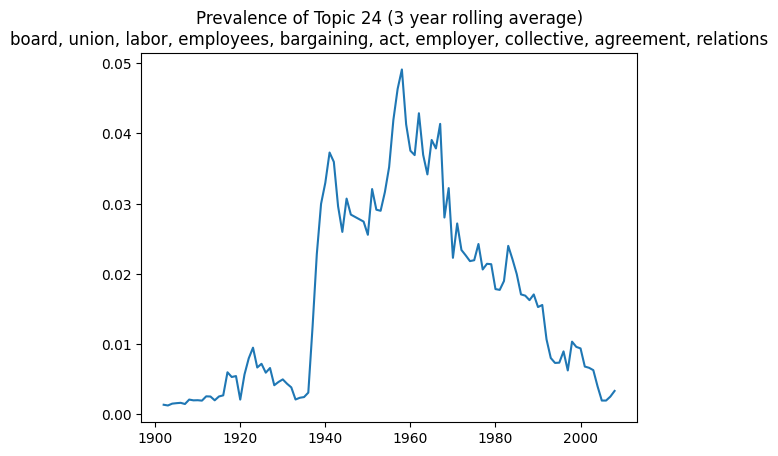

In [49]:
import matplotlib.pyplot as plt

window = 3
topic_proportion_rolling = topic_proportion_by_year.loc[1900:, labor_topic].rolling(
    window=window).mean()
topic_proportion_rolling.plot()
plt.title(f'Prevalence of {labor_topic} ({window} year rolling average)'
          f'\n{topic_top_words_joined}');

# Easy

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
import pandas as pd
import sklearn.feature_extraction.text as text
import numpy as np

In [4]:
df = pd.read_csv('old-bailey.csv.gz', parse_dates=True, index_col='id')
df['date'] = pd.to_datetime(df['date'])

<ipython-input-4-3102fdf8e1b1>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('old-bailey.csv.gz', parse_dates=True, index_col='id')


In [202]:
df_19thc = df[(df['date'] > '1800-01-01') & (df['date'] < '1899-12-31')]

In [6]:
print("Number of documents", df_19thc.shape[0])
print("Number of guilty verdicts", df_19thc[df_19thc['verdict'] == 'guilty'].shape[0])
print("Most common offence: \n", df_19thc.groupby('offence').count()['text'].sort_values(ascending=False).head(1)) # most common offence is theft
print("Most popular months: \n", df_19thc.groupby(df_19thc['date'].dt.month).count()['text'].sort_values(ascending=False).head(3)) # most popular month is april, followed by january and july

Number of documents 26014
Number of guilty verdicts 20017
Most common offence: 
 offence
theft    18545
Name: text, dtype: int64
Most popular months: 
 date
4    3419
1    3361
7    3057
Name: text, dtype: int64


In [7]:
df_19thc.groupby(df_19thc['date'].dt.month).count()['text'].sort_values(ascending=False).head(4)

,text
date,
4,3419
1,3361
7,3057
2,3000


In [8]:
vec = text.CountVectorizer(lowercase=True, min_df=100, stop_words='english', decode_error='ignore')
dtm = vec.fit_transform(df_19thc['text'].apply(lambda x: np.str_(x))) # convert dtype object to string

In [9]:
import sklearn.decomposition as decomposition
model = decomposition.LatentDirichletAllocation(
    n_components=40, # only around 10 total offences
    learning_method='online',
    random_state=1)

In [10]:
document_topic_distributions = model.fit_transform(dtm)

In [11]:
vocabulary = vec.get_feature_names_out()
assert model.components_.shape == (40, len(vocabulary))
assert document_topic_distributions.shape == (dtm.shape[0], 40)

In [12]:
vocabulary = vec.get_feature_names_out()
topic_names = [f'Topic {k}' for k in range(40)]
topic_word_distributions = pd.DataFrame(
    model.components_, columns=vocabulary, index=topic_names)

document_topic_distributions = pd.DataFrame(
    document_topic_distributions, columns=topic_names, index=df_19thc.index)

In [13]:
print(document_topic_distributions.shape)
print(topic_word_distributions.shape)

(26014, 40)
(40, 3652)


# Moderate

In [14]:
document_topic_distributions.loc['t18680406-385'].sort_values(ascending=False).head(10) # topics 8, 5 & 2 seem to be most relevant

,t18680406-385
Topic 8,0.505351
Topic 5,0.198553
Topic 2,0.122771
Topic 6,0.065121
Topic 31,0.046156
Topic 16,0.031669
Topic 4,0.012336
Topic 39,0.008913
Topic 25,0.004034
Topic 26,0.002518


In [15]:
print(df_19thc.loc['t18680406-385']['text'][:2000])
topic_word_distributions.loc['Topic 8'].sort_values(ascending=False).head(10) # seems pretty accurate given the output

385. RICHARD BISHOP (21) , was indicted for the wilful murder of Alfred Cartwright . He was also charged on the Coroner's Inquisition with the like offence. MESSRS. POLAND and BEASLEY conducted the Prosecution; and MR. SLEIGH the Defence . MATILDA CARTWRIGHT . I am the wife of Henry Cartwright, a shoemaker, of 1, South Street, Forest Hill — the deceased, Alfred Cartwright, was my son — he was twenty-seven years of age in June last — he had a wife and three children, and another expected — he had a little shop, which his wife managed — he himself had been for nearly four years potman at the Swiss Cottage — last Thursday night, 2nd April, from 11 o'clock till half-past, I went to the Swiss Cottage, to get half a pint of beer for my supper — I found my son there, and my husband also — I did not get my beer — my husband, my son, and I shortly proceeded to come home together — I accompanied my son to his house; I was going to see his wife — when we got to the house, we found several persons

,Topic 8
prisoner,10962.742902
did,7984.241555
said,6353.442573
saw,5684.914138
went,4658.819798
head,4377.303978
came,4308.427503
struck,3609.148118
deceased,3567.374359
heard,3134.465154


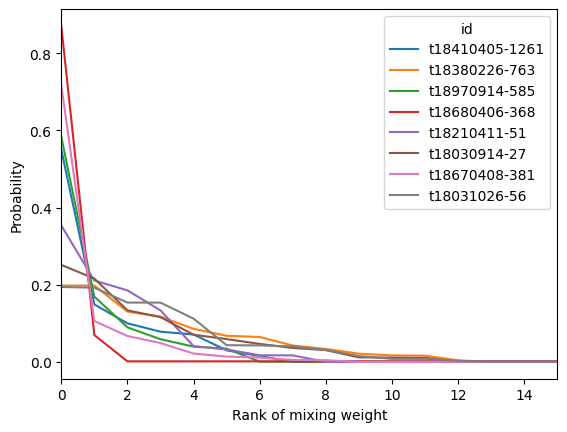

In [17]:
weights_sample = document_topic_distributions.sample(8)
weights_ordered = weights_sample.apply(
    lambda row: row.sort_values(ascending=False).reset_index(drop=True), axis=1)
# transpose DataFrame so pandas plots weights on correct axis
ax = weights_ordered.T.plot()
ax.set(xlabel='Rank of mixing weight', ylabel='Probability', xlim=(0, 15));

Most weights do not contribute much to the probability. This is probably because the cases deal with only a few areas of law, rather than many. Each case is quite short and only addresses around 12 topics maximum.

In [100]:
top_words_per_topic = np.transpose(topic_word_distributions).apply(lambda row: ', '.join(row.sort_values(ascending=False).head(5).index))
top_words_per_topic.head()

,0
Topic 0,"board, ship, captain, boat, allen"
Topic 1,"davis, taylor, 29th, dec, cole"
Topic 2,"said, prisoner, asked, came, did"
Topic 3,"house, door, room, went, open"
Topic 4,"shop, window, saw, street, door"


In [101]:
dtd_off = document_topic_distributions.join(df_19thc['offence'], on='id')
topic_names = document_topic_distributions.columns
df_plot = dtd_off.groupby('offence')[topic_names].mean() # take average rather than just summing

df_plot = df_plot.rename(
    columns={
        f'{t[0]}': f'{t[0]}: {t[1]}'
        for t in top_words_per_topic.items()
    }
)
df_plot

,"Topic 0: board, ship, captain, boat, allen","Topic 1: davis, taylor, 29th, dec, cole","Topic 2: said, prisoner, asked, came, did","Topic 3: house, door, room, went, open","Topic 4: shop, window, saw, street, door","Topic 5: saw, said, examined, went, cross","Topic 6: watch, prisoner, said, prosecutor, did","Topic 7: prisoner, mrs, said, husband, wife","Topic 8: prisoner, did, said, saw, went","Topic 9: smith, november, van, jackson, watson",...,"Topic 30: horse, horses, stable, coach, saw","Topic 31: mr, think, time, said, case","Topic 32: pair, bundle, coat, hat, value","Topic 33: mr, bought, sold, examined, cross","Topic 34: letter, office, said, mr, prisoner","Topic 35: cart, mr, sack, sacks, saw","Topic 36: did, mr, yes, know, time","Topic 37: lead, sugar, meat, weight, bread","Topic 38: note, bank, notes, pound, money","Topic 39: gave, half, prisoner, bad, shilling"
offence,,,,,,,,,,,,,,,,,,,,,
breakingPeace,0.005418,0.002468,0.028043,0.014202,0.011163,0.067941,0.049415,0.028459,0.227765,0.004272,...,0.005405,0.025916,0.003765,0.005029,0.017780,0.003568,0.042360,0.002863,0.001321,0.005129
damage,0.003228,0.003379,0.045439,0.089967,0.049958,0.128984,0.014229,0.035078,0.050713,0.008912,...,0.021534,0.046755,0.002049,0.005287,0.021834,0.002451,0.044136,0.003306,0.001502,0.003268
deception,0.004288,0.003707,0.057318,0.005553,0.004507,0.031351,0.005308,0.013774,0.004926,0.006227,...,0.004945,0.031854,0.003598,0.008546,0.080955,0.004032,0.049338,0.003447,0.014836,0.015920
kill,0.006073,0.002796,0.023830,0.014753,0.012020,0.068708,0.019017,0.022447,0.345896,0.004566,...,0.015699,0.039671,0.003502,0.003437,0.009673,0.008667,0.068216,0.002591,0.001403,0.002920
miscellaneous,0.005616,0.005580,0.033375,0.006960,0.005094,0.023638,0.015434,0.017999,0.020493,0.006133,...,0.004960,0.028445,0.004150,0.007582,0.027223,0.004519,0.055802,0.005911,0.003932,0.012794
royalOffences,0.002154,0.002937,0.087116,0.009885,0.013906,0.067920,0.014649,0.012640,0.005120,0.006248,...,0.003574,0.008845,0.003078,0.003702,0.013251,0.002277,0.030371,0.003769,0.014367,0.336727
sexual,0.003674,0.005437,0.009776,0.002213,0.003152,0.006114,0.004412,0.036614,0.004994,0.009495,...,0.003107,0.010978,0.002772,0.004046,0.011848,0.004265,0.026516,0.004177,0.001915,0.002545
theft,0.004864,0.004264,0.053960,0.034939,0.030417,0.035187,0.033625,0.054523,0.005437,0.006381,...,0.011099,0.007121,0.018206,0.015784,0.012711,0.006641,0.035831,0.007556,0.006533,0.019596
violentTheft,0.003431,0.002768,0.023857,0.012403,0.012461,0.169221,0.280654,0.021925,0.034061,0.004978,...,0.006362,0.005908,0.009158,0.002714,0.005604,0.003146,0.050167,0.001647,0.005499,0.023363


Text(0.5, 1.0, 'Topic model and offence label alignment for Old Bailey cases')

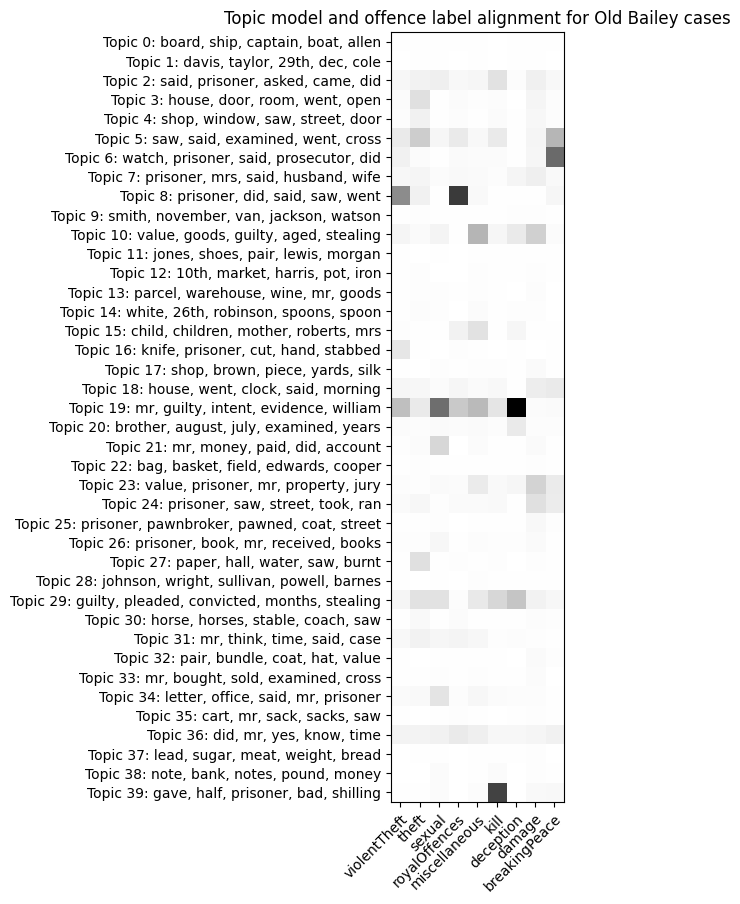

In [102]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.transpose(df_plot.values), cmap='Greys')

ax.set_yticks(np.arange(len(df_plot.columns)))
ax.set_xticks(np.arange(len(df_plot.index)))
ax.set_yticklabels(df_plot.columns)
ax.set_xticklabels(reversed(df_plot.index))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title('Topic model and offence label alignment for Old Bailey cases')

All cases seem to have some similarity with "guilty" and "intent" but to "deception" is the highest likelihood there. Many of the cases involve prisoners. Cases involved with breaking the peace seem to have more watchfulness from the state, and cases involving children seem to be more "miscellaneous", suggesting they don't fall neatly into one of the other categories. Cases involving royal offences seem to be mostly about the legal procedure rather than the king, and theft-related cases have more to do with place (house, shop, window, etc).

A future analysis might exclude titles like "Mr" to clean up the data since it appears to have little effect on the results.

# Challenging

In [220]:
import sklearn.neighbors

In [221]:
import sklearn

vectorizer = text.CountVectorizer(max_features=10000, token_pattern=r"(?u)\b\w+\b")
v_texts = vectorizer.fit_transform(df_19thc['text'].astype('U')).toarray()

# fit a PCA to the old bailey data
pca = sklearn.decomposition.PCA(n_components=40)
documents_proj = pca.fit_transform(v_texts)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

In [222]:
documents_proj.shape

(50017, 40)

In [223]:
classifier = sklearn.neighbors.KNeighborsClassifier()

# drop where offences are NaN
df_19thc['id'] = df_19thc.index
df_19thc = df.reset_index()

df_19thc.join(pd.DataFrame(documents_proj))
df_19thc = df_19thc.dropna(subset=['offence'])

offences = df_19thc['offence']

In [224]:
# split into test & train
msk = np.random.rand(len(df_19thc)) < 0.5
train_docs = documents_proj[msk]
train_offences = df_19thc['offence'][msk]
test_docs = documents_proj[~msk]
test_offences = df_19thc['offence'][~msk]

In [225]:
classifier.fit(train_docs, train_offences)

[[ 1.68098146e+02 -1.22282241e+01 -1.45987825e+01 ... -1.33434170e+01
   7.27905587e+00  7.67209062e+00]
 [ 3.32037309e+01  1.15802415e+00 -1.22857914e+01 ... -4.78678069e+00
  -5.31014994e-01 -1.83751862e+00]
 [ 1.52611662e+02  1.30451384e+01 -1.37288144e+01 ... -4.44955892e+00
   3.57491388e+00  8.98451446e+00]
 ...
 [-6.09464048e+01  1.76037002e+00  4.80723548e-01 ...  1.45145459e-01
  -4.62811809e-01 -1.12698644e-01]
 [-6.07229385e+01  1.72646686e+00  4.64414682e-01 ...  1.02369334e-01
  -4.06314587e-01 -3.35648057e-01]
 [-6.11076931e+01  1.89189523e+00  3.79374969e-01 ...  1.95226084e-01
  -5.27946334e-01 -3.19886827e-01]]


KNeighborsClassifier()

In [227]:
offences_predicted = classifier.predict(test_docs)

In [232]:
from sklearn.metrics import classification_report

print(classification_report(test_offences, offences_predicted))

               precision    recall  f1-score   support

breakingPeace       0.41      0.34      0.37       663
       damage       0.43      0.11      0.17       110
    deception       0.60      0.47      0.52      1504
         kill       0.64      0.43      0.52       617
miscellaneous       0.46      0.29      0.35       300
royalOffences       0.70      0.54      0.61      1073
       sexual       0.67      0.43      0.53       727
        theft       0.87      0.96      0.91     18715
 violentTheft       0.64      0.28      0.39      1245

     accuracy                           0.82     24954
    macro avg       0.60      0.43      0.49     24954
 weighted avg       0.80      0.82      0.81     24954



Predictions are most often correct for theft, which makes sense since it has a distinct vocabulary (e.g. stealing, thief), vs breaking the peace or damage which could be somewhat similar. Theft is also the most common crime in the dataset, so it's probably correct to guess "theft" when in doubt.

I'm surprised to see that theft and violentTheft have such different precisions, but I imagine that violentTheft might get misconstrued as kill. RoyalOffences also has quite a high precision, which I imagine is due to it having a particular vocabulary. I might also expect a specific vocabulary, particularly a higher incidence of feminine words in the "sexual" category.